# XGBoost

## Imports

In [68]:
import xgboost as xgb
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
import pandas as pd

In [69]:
TRAIN_CSV = '../data/activity_train.csv'   # path to train CSV
TEST_CSV  = '../data/activity_test.csv'    # path to test CSV

label_map = {
    1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
    4:'SITTING', 5:'STANDING', 6:'LAYING',
    7:'STAND_TO_SIT', 8:'SIT_TO_STAND', 9:'SIT_TO_LIE',
    10:'LIE_TO_SIT', 11:'STAND_TO_LIE', 12:'LIE_TO_STAND'
}

RANDOM_STATE = 42

In [70]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)
print('train shape:', df_train.shape)
print('test  shape:', df_test.shape)

X_train = df_train.drop(columns=['activity'])
y_train = df_train['activity'].copy()
X_test = df_test.drop(columns=['activity'])
y_test = df_test['activity'].copy()

train_cols = list(X_train.columns)
test_cols = list(X_test.columns)
X_test = X_test[train_cols]

labels = np.unique(y_test)
label_names = [label_map.get(int(l), str(l)) for l in labels]

train shape: (7767, 562)
test  shape: (3162, 562)


In [71]:
sw = compute_sample_weight(class_weight='balanced', y=y_train)

base_params = dict(objective='multi:softprob',
                   use_label_encoder=False,
                   eval_metric='mlogloss',
                   n_estimators=1000,
                   learning_rate=0.05,
                   max_depth=6,
                   subsample=0.8,
                   colsample_bytree=0.8,
                   random_state=RANDOM_STATE,
                   n_jobs=-1)

In [72]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
val_scores = []
best_iters = []

/Users/martynas/Documents/personal/projects/machine-learning-project/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [00:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/martynas/Documents/personal/projects/machine-learning-project/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [00:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/martynas/Documents/personal/projects/machine-learning-project/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [00:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/martynas/Documents/personal/projects/machine-learning-

CV f1_macro mean/std: 0.890777461614686 0.012094826446921031
median best_iteration: 1000


/Users/martynas/Documents/personal/projects/machine-learning-project/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [00:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test F1 macro: 0.851330543894076
              precision    recall  f1-score   support

           1     0.9290    0.9758    0.9518       496
           2     0.9158    0.9236    0.9197       471
           3     0.9795    0.9119    0.9445       420
           4     0.9340    0.8917    0.9124       508
           5     0.9085    0.9460    0.9269       556
           6     1.0000    0.9982    0.9991       545
           7     0.8400    0.9130    0.8750        23
           8     0.7143    1.0000    0.8333        10
           9     0.7429    0.8125    0.7761        32
          10     0.6667    0.6400    0.6531        25
          11     0.8372    0.7347    0.7826        49
          12     0.6538    0.6296    0.6415        27

    accuracy                         0.9333      3162
   macro avg     0.8435    0.8648    0.8513      3162
weighted avg     0.9341    0.9333    0.9331      3162



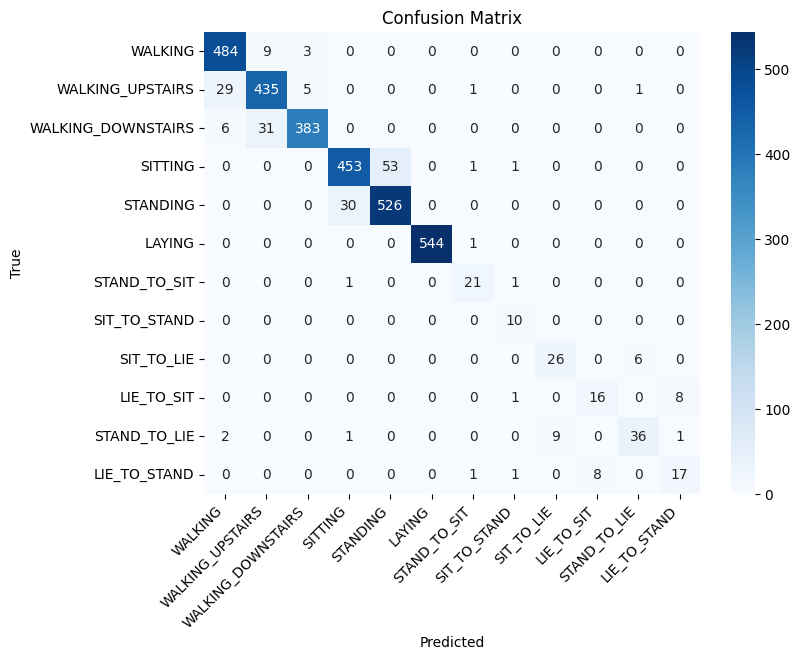

In [ ]:
y_train_shifted = y_train - 1
num_class = len(np.unique(y_train_shifted))

params_common = {
    'objective': 'multi:softprob',
    'eta': base_params['learning_rate'],
    'max_depth': base_params['max_depth'],
    'subsample': base_params['subsample'],
    'colsample_bytree': base_params['colsample_bytree'],
    'seed': RANDOM_STATE,
    'eval_metric': 'mlogloss',
    'num_class': num_class,
    'verbosity': 0
}

val_scores = []
best_iters = []

for train_idx, val_idx in cv.split(X_train, y_train_shifted):
    Xtr, Xval = X_train.iloc[train_idx], X_train.iloc[val_idx]
    ytr, yval = y_train_shifted.iloc[train_idx], y_train_shifted.iloc[val_idx]
    swtr = compute_sample_weight(class_weight='balanced', y=ytr)

    dtrain = xgb.DMatrix(Xtr, label=ytr, weight=swtr)
    dval = xgb.DMatrix(Xval, label=yval)
    evallist = [(dval, 'eval')]

    bst = xgb.train(params_common,
                    dtrain,
                    num_boost_round=base_params['n_estimators'],
                    evals=evallist,
                    early_stopping_rounds=30,
                    verbose_eval=False)

    preds = np.argmax(bst.predict(dval), axis=1)
    val_scores.append(f1_score(yval, preds, average='macro'))
    best_iters.append(getattr(bst, 'best_iteration', base_params['n_estimators']))

print('CV f1_macro mean/std:', np.mean(val_scores), np.std(val_scores))
print('median best_iteration:', int(np.median(best_iters)))

# final train on full training set using median best_iteration
final_n_estimators = int(np.median([b if b is not None else base_params['n_estimators'] for b in best_iters]))
sw_shifted = compute_sample_weight(class_weight='balanced', y=y_train_shifted)
dtrain_full = xgb.DMatrix(X_train, label=y_train_shifted, weight=sw_shifted)
bst_final = xgb.train(params_common, dtrain_full, num_boost_round=final_n_estimators, verbose_eval=False)

# evaluate on test
dtest = xgb.DMatrix(X_test)
y_pred = np.argmax(bst_final.predict(dtest), axis=1) + 1  # convert back to 1..12
print('Test F1 macro:', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(rotation=45, ha='right'); plt.show()

In [ ]:
# Parameter sweep (CV f1_macro) + test f1 per subset using xgb.train
def split_time_freq_columns(cols):
    time_cols = [c for c in cols if c.lower().startswith('t')]
    freq_cols = [c for c in cols if c.lower().startswith('f') or 'freq' in c.lower() or 'fft' in c.lower()]
    freq_cols = [c for c in freq_cols if c not in time_cols]
    return time_cols, freq_cols

time_cols, freq_cols = split_time_freq_columns(X_train.columns.tolist())
combined_cols = list(dict.fromkeys(time_cols + freq_cols))

def ensure_and_order(X_src, cols):
    X = X_src.copy()
    for c in cols:
        if c not in X.columns:
            X[c] = 0.0
    return X[cols]

subsets = {
    'time': (ensure_and_order(X_train, time_cols), ensure_and_order(X_test, time_cols)),
    'freq': (ensure_and_order(X_train, freq_cols), ensure_and_order(X_test, freq_cols)),
    'combined': (ensure_and_order(X_train, combined_cols), ensure_and_order(X_test, combined_cols)),
    'all': (X_train, X_test)
}

y_train_shifted = y_train - 1
sw_shifted = compute_sample_weight(class_weight='balanced', y=y_train_shifted)
num_class = len(np.unique(y_train_shifted))

max_depths = [3, 6, 9]
learning_rates = [0.01, 0.05, 0.1]
param_list = [{'max_depth': d, 'learning_rate': lr} for d in max_depths for lr in learning_rates]
param_names = [f"md{p['max_depth']}_lr{p['learning_rate']}" for p in param_list]

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
cv_f1_results = {name: [] for name in subsets}
test_f1_results = {name: [] for name in subsets}
best_iters_store = {name: [] for name in subsets}  # store median iters per param

for subset_name, (Xtr_full, Xte_full) in subsets.items():
    print(f"\n--- subset: {subset_name} ---")
    for p_idx, params in enumerate(param_list):
        params_xgb = {
            'objective': 'multi:softprob',
            'eta': params['learning_rate'],
            'max_depth': params['max_depth'],
            'subsample': base_params['subsample'],
            'colsample_bytree': base_params['colsample_bytree'],
            'seed': RANDOM_STATE,
            'eval_metric': 'mlogloss',
            'num_class': num_class,
            'verbosity': 0
        }

        fold_scores = []
        best_iters = []
        for train_idx, val_idx in cv.split(Xtr_full, y_train_shifted):
            Xtr = Xtr_full.iloc[train_idx]; Xval = Xtr_full.iloc[val_idx]
            ytr = y_train_shifted.iloc[train_idx]; yval = y_train_shifted.iloc[val_idx]
            swtr = compute_sample_weight(class_weight='balanced', y=ytr)

            dtrain = xgb.DMatrix(Xtr, label=ytr, weight=swtr)
            dval = xgb.DMatrix(Xval, label=yval)
            evallist = [(dval, 'eval')]

            bst = xgb.train(params_xgb,
                            dtrain,
                            num_boost_round=base_params['n_estimators'],
                            evals=evallist,
                            early_stopping_rounds=30,
                            verbose_eval=False)

            preds = np.argmax(bst.predict(dval), axis=1)
            fold_scores.append(f1_score(yval, preds, average='macro'))
            best_iters.append(getattr(bst, 'best_iteration', base_params['n_estimators']))

        cv_mean = np.mean(fold_scores)
        cv_f1_results[subset_name].append(cv_mean)

        median_iter = int(np.median([b if b is not None else base_params['n_estimators'] for b in best_iters]))
        best_iters_store[subset_name].append(median_iter)

        # final train for this param/subset
        dtrain_full = xgb.DMatrix(Xtr_full, label=y_train_shifted, weight=sw_shifted)
        bst_final = xgb.train(params_xgb, dtrain_full, num_boost_round=median_iter, verbose_eval=False)

        dtest = xgb.DMatrix(Xte_full)
        y_pred = np.argmax(bst_final.predict(dtest), axis=1) + 1
        test_f1 = f1_score(y_test, y_pred, average='macro')
        test_f1_results[subset_name].append(test_f1)

        print(f"{param_names[p_idx]}  CV f1_macro={cv_mean:.4f}  Test f1_macro={test_f1:.4f}  median_iter={median_iter}")

# Plot results
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for name, vals in cv_f1_results.items():
    plt.plot(param_names, vals, marker='o', label=name)
plt.xticks(rotation=45, ha='right'); plt.xlabel('param (max_depth_learning_rate)'); plt.ylabel('CV f1_macro')
plt.title('CV f1_macro for XGBoost param sweep'); plt.legend()

plt.subplot(1,2,2)
for name, vals in test_f1_results.items():
    plt.plot(param_names, vals, marker='o', label=name)
plt.xticks(rotation=45, ha='right'); plt.xlabel('param (max_depth_learning_rate)'); plt.ylabel('Test f1_macro')
plt.title('Test f1_macro for XGBoost param sweep'); plt.legend()
plt.tight_layout(); plt.show()

# Confusion matrices for best param per subset
print("\nConfusion matrices for best CV param per subset:")
for name in subsets:
    best_idx = int(np.argmax(cv_f1_results[name]))
    best_param = param_list[best_idx]
    best_iter = best_iters_store[name][best_idx]
    print(f"\n=== {name} (best param: md={best_param['max_depth']}, lr={best_param['learning_rate']}, iter={best_iter}) ===")

    params_xgb = {
        'objective': 'multi:softprob',
        'eta': best_param['learning_rate'],
        'max_depth': best_param['max_depth'],
        'subsample': base_params['subsample'],
        'colsample_bytree': base_params['colsample_bytree'],
        'seed': RANDOM_STATE,
        'eval_metric': 'mlogloss',
        'num_class': num_class,
        'verbosity': 0
    }

    Xtr_full, Xte_full = subsets[name]
    dtrain_full = xgb.DMatrix(Xtr_full, label=y_train_shifted, weight=sw_shifted)
    bst_best = xgb.train(params_xgb, dtrain_full, num_boost_round=best_iter, verbose_eval=False)
    y_pred = np.argmax(bst_best.predict(xgb.DMatrix(Xte_full)), axis=1) + 1

    print('Test F1 macro:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{name} Confusion Matrix (best param={param_names[best_idx]})'); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(rotation=45, ha='right'); plt.show()


--- subset: time ---


/Users/martynas/Documents/personal/projects/machine-learning-project/.venv/lib/python3.11/site-packages/xgboost/core.py:771: FutureWarning: Pass `rounds` as keyword args.
  warnings.warn(msg, FutureWarning)


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'callbacks'